In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import open3d
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Prepare Camera

In [3]:
from pycamcal.camera_model import CameraModel
from pycamcal.camera_model import RadialTangentialDistortion

distortion = RadialTangentialDistortion(
    k1=-0.2,
    k2=0.01,
    k3=0.00,
    p1=0.01,
    p2=0.00
)

camera = CameraModel.from_fov(
    res_xy = (1200, 1000),
    fov_xy = (72, 60),
    distortion = distortion
)

print(camera)

undistorting rays: 100%|██████████| 480/480 [00:00<00:00, 5586.96it/s]


<Axes: >

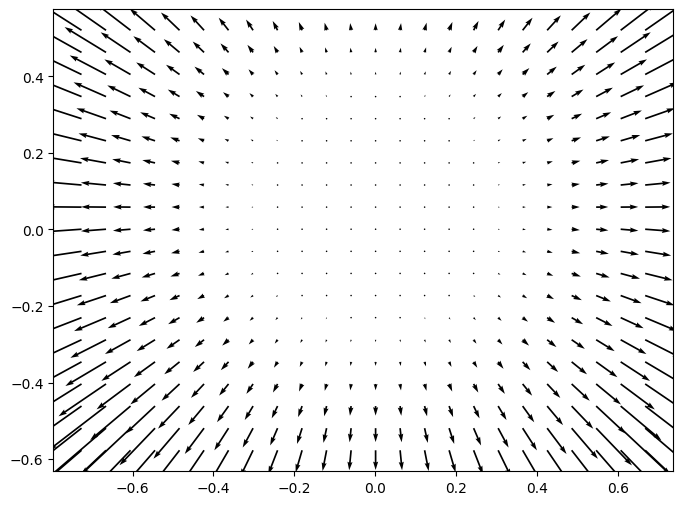

In [4]:
from pycamcal.camera_model.viz_utils import visualize_distortion_model

fig, ax = plt.subplots(figsize=(8, 6))
visualize_distortion_model(camera, subsample=50, exaggeration=0.5, ax=ax)

## Generate Dataset

In [5]:
from pycamcal.simulation.dataset_generation import generate_calibration_dataset

num_images = 20

images, camera_poses, scene = generate_calibration_dataset(camera, num_images, random_seed=1337)

undistorting rays: 100%|██████████| 1200000/1200000 [00:02<00:00, 568597.50it/s]
20it [04:50, 14.53s/it]


In [6]:
from pycamcal.simulation.viz_utils import visualize_camera_positioning

visualize_camera_positioning(scene, camera, camera_poses, camera_viz_scale=0.5)

In [7]:
def pad_text_to_constant_line_width(text, pad_char=" "):
    lines = text.split("\n")
    max_line_len = max(len(line) for line in lines)
    return "\n".join(
        line.ljust(max_line_len, pad_char)
        for line in lines
    )

In [8]:
def place_info_textbox(fig, x, y, text, box_width_chars=None):
    if box_width_chars is not None:
        lines = text.split("\n")
        text = "\n".join(line.ljust(box_width_chars) for line in lines)

    return fig.text(x, y, text,
        fontsize=9,
        verticalalignment="top",
        horizontalalignment="left",
        fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    )

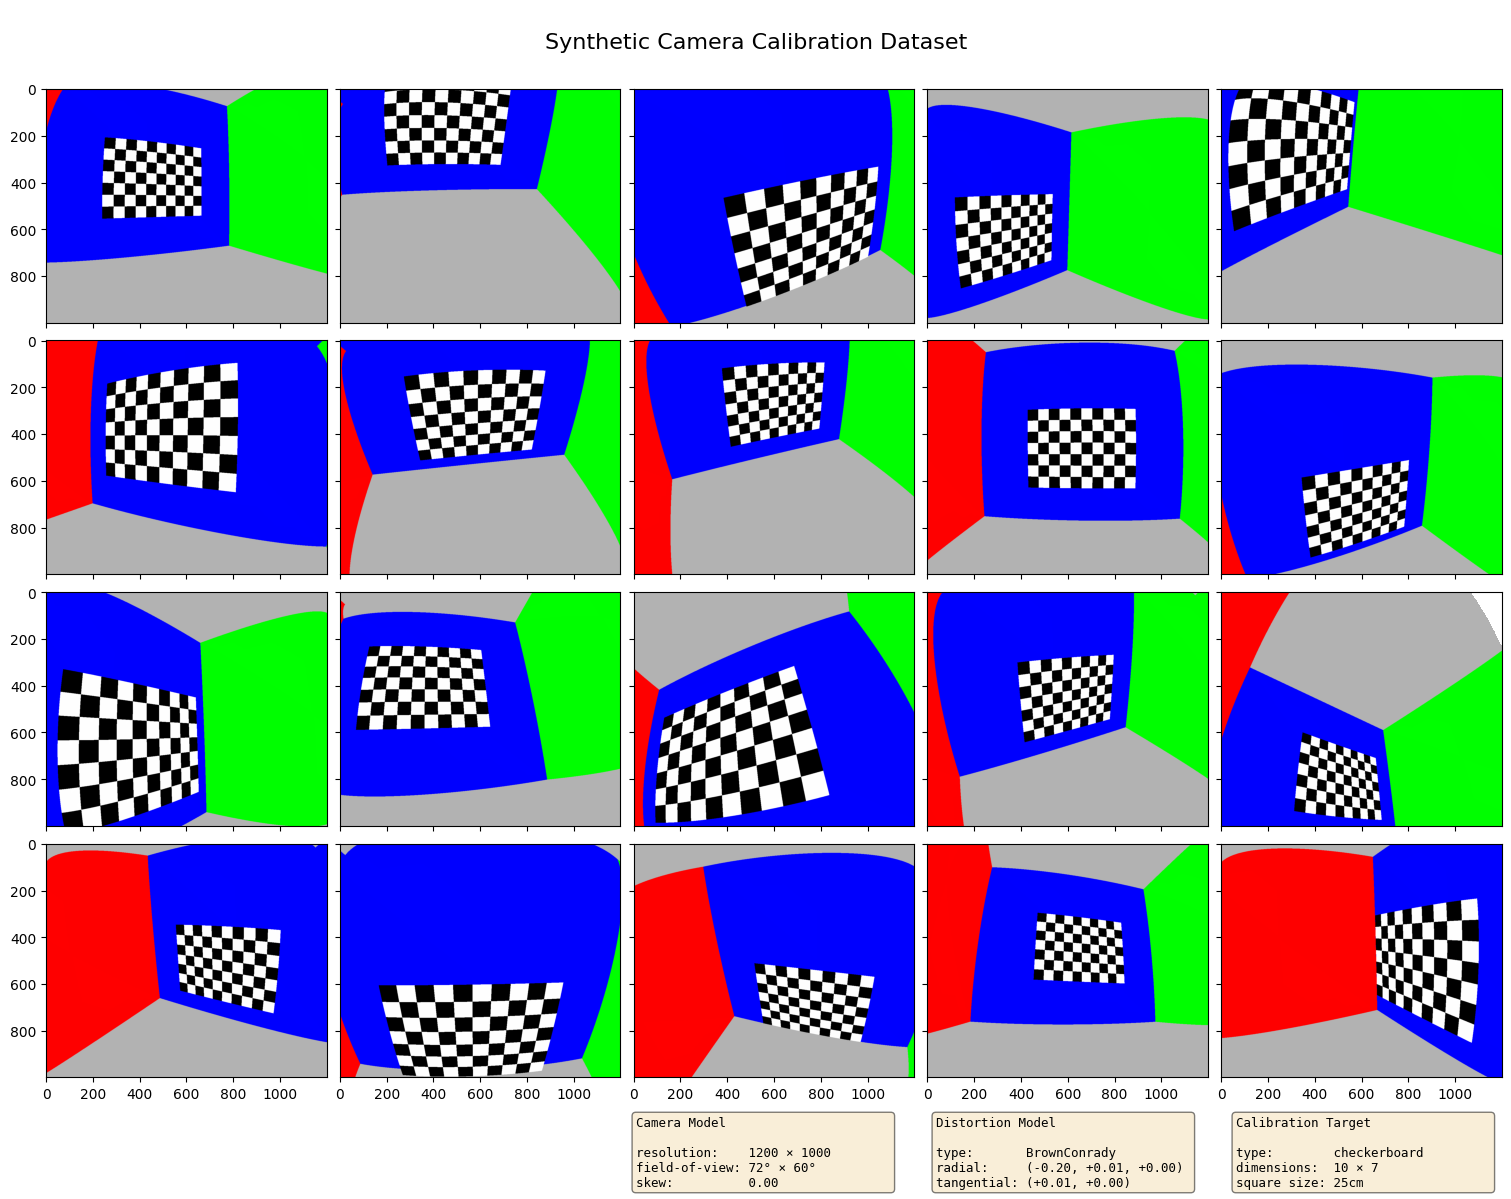

In [13]:
nrows = 4
ncols = 5

image_aspect_ratio = camera.res_xy[1] / camera.res_xy[0]
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(ncols*3, nrows*3*image_aspect_ratio+1.0),
    sharex="all", sharey="all", layout="constrained"
)

fig.suptitle(f"\nSynthetic Camera Calibration Dataset\n", fontsize=16)

# plot images
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i])

# create info boxes

fov_x, fov_y = camera.get_fov(degrees=True)

info_text_cmod = f"""\
Camera Model

resolution:    {camera.res_xy[0]} × {camera.res_xy[1]}
field-of-view: {fov_x:.0f}° × {fov_y:.0f}°
skew:          0.00\
"""

info_text_dist = f"""\
Distortion Model

type:       BrownConrady
radial:     ({distortion.k1:+.2f}, {distortion.k2:+.2f}, {distortion.k3:+.2f})
tangential: ({distortion.p1:+.2f}, {distortion.p2:+.2f})\
"""

info_text_calib = f"""\
Calibration Target

type:        checkerboard
dimensions:  10 × 7
square size: 25cm\
"""

place_info_textbox(fig, 0.42, -0.01, info_text_cmod,  box_width_chars=34)
place_info_textbox(fig, 0.62, -0.01, info_text_dist,  box_width_chars=34)
place_info_textbox(fig, 0.82, -0.01, info_text_calib, box_width_chars=34)


fig.savefig("media/synthetic_calibration_dataset_image_grid.png", bbox_inches="tight")